## Ideas

- Augmentor (rotation +  noise)
- patches in patch...
- learn background
- distance to road loss
- deeeeeeeeper
- histogram matching
- post processing
- batchnorm
- 

In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
from sklearn.metrics import f1_score

import tensorflow as tf



In [2]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

def normalize_data(data):
    # Data pre-processing, Normalize each image with itself
    n = data.shape[0]
    for i in range(n):
        xx = data[i]
        xx -= np.mean(xx) # Centering in 0
        #xx /= np.linalg.norm(xx) # Normalizing to 1
        data[i] = xx # Affect value
    return data
def one_hot_convert(vector, num_classes=None):
    """ (From https://stackoverflow.com/questions/29831489/numpy-1-hot-array)
    Converts an input 1-D vector of integers into an output
    2-D array of one-hot vectors, where an i'th input value
    of j will set a '1' in the i'th row, j'th column of the
    output array.

    Example:
        v = np.array((1, 0, 4))
        one_hot_v = convertToOneHot(v)
        print one_hot_v

        [[0 1 0 0 0]
         [1 0 0 0 0]
         [0 0 0 0 1]]
    """

    assert isinstance(vector, np.ndarray)
    assert len(vector) > 0

    if num_classes is None:
        num_classes = np.max(vector)+1
    else:
        assert num_classes > 0
        assert num_classes >= np.max(vector)

    result = np.zeros(shape=(len(vector), num_classes))
    result[np.arange(len(vector)), vector] = 1
    return result

def get_patches_all(x_data, y_label=None, patch_size=16):
    # Ccompute final siz of array of patches
    n_patch_h = x_data.shape[1] // patch_size
    n_patch_w = x_data.shape[2] // patch_size
    x_patches = np.zeros((x_data.shape[0]*n_patch_h*n_patch_w, patch_size, patch_size) + x_data.shape[3:])
    y_patches = np.zeros((x_data.shape[0]*n_patch_h*n_patch_w, patch_size, patch_size))
    
    # Iterate over all images to convert them to patches
    for i in range(x_data.shape[0]):
        y_temp = None
        if y_label is not None:
            y_temp = y_label[i]
        x_patches[i*(n_patch_h*n_patch_w):(i+1)*(n_patch_h*n_patch_w)], \
        y_patches[i*(n_patch_h*n_patch_w):(i+1)*(n_patch_h*n_patch_w)] = get_patches(x_data[i], y_temp, patch_size)
        
    # Compute label for gt (Each patch is either road or background)
    y_batch_label = get_patches_label(y_patches)
    return x_patches, y_patches, y_batch_label

def get_patches(x_data, y_label=None, patch_size=16):
    # Check if dimension are ok (x_data shapes are mulitples of patch)
    assert(x_data.shape[0] % patch_size == 0 and x_data.shape[1] % patch_size == 0)
    # Create new array that will contain all the patches
    n_patch_h = x_data.shape[0] // patch_size
    n_patch_w = x_data.shape[1] // patch_size
    x_patches = np.zeros((n_patch_h, n_patch_w, patch_size, patch_size) + x_data.shape[2:])
    y_patches = np.zeros((n_patch_h, n_patch_w, patch_size, patch_size))
    # Iterate over all batches
    for i in range(n_patch_h):
        for j in range(n_patch_w):
            x_patches[i, j] = x_data[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            if y_label is not None:
                y_patches[i, j] = y_label[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
    # Reshape tu have first dimension as linear feature instead of n_patch_h X n_patch_w
    x_patches = np.reshape(x_patches, (-1, patch_size, patch_size) + x_data.shape[2:])
    y_patches = np.reshape(y_patches, (-1, patch_size, patch_size))
    return x_patches, y_patches

def get_patches_label(y_batch):
    # Create vector of one and zeros (1 is road, 0 is background)
    y_label_unique = np.zeros((y_batch.shape[0]))
    # Take mean value of pixel to estiamte road yes or not
    for i in range(y_batch.shape[0]):
        y_label_unique[i] = np.around(np.mean(y_batch[i]))
    return y_label_unique

def get_useful_patches(patch_x, patch_y, min_threshold, max_threshold):
    """ From an array of [Num_patches x H x W x Num_channels] and its associated pixelwise labels,
    return patches with label mean > threshold"""

    first_patch=True
    for i in range(patch_x.shape[0]):
        if np.mean(patch_y[i])>min_threshold and np.mean(patch_y[i])<max_threshold:
            if first_patch:
                useful_patches_x =  np.expand_dims(patch_x[i], axis=0)
                useful_patches_y = np.expand_dims(patch_y[i],axis=0)
                first_patch=False
            else:
                useful_patches_x = np.append(useful_patches_x, np.expand_dims(patch_x[i],axis=0), axis=0)
                useful_patches_y = np.append(useful_patches_y, np.expand_dims(patch_y[i], axis=0), axis=0)

    return useful_patches_x, useful_patches_y

def predict_model(sess, preds_tf, loss_tf, tf_data, tf_labels, keep_prob, imgs, gt, nmax=5, size_out=400):
    imgs_size = gt.shape[0]
    splits = np.linspace(0, imgs_size, 1+imgs_size//nmax).astype(int)
    
    pred_tot = np.empty(0)
    loss_tot = np.empty(0)
    
    for i in range(splits.shape[0]-1):
        # Get batches
        batch_img = imgs[splits[i]:splits[i+1]]
        batch_gt = gt[splits[i]:splits[i+1]]
        batch_len = splits[i+1]-splits[i]
        batch_labels = one_hot_convert(np.reshape(batch_gt, batch_len*size_out*size_out).astype(int),2)
        # Run model on batch
        pred, loss = sess.run([preds_tf, loss_tf], 
                           feed_dict={tf_data : batch_img, tf_labels : batch_labels, keep_prob : 1})
        # Concatenate prediction and loss
        pred_tot = np.concatenate((pred_tot, pred), axis=0)
        loss_tot = np.concatenate((loss_tot, [loss]), axis=0)
        
    f1 = f1_score(np.reshape(gt, imgs_size*size_out*size_out), np.reshape(pred_tot, [-1]), average='macro') 
    loss = np.mean(loss_tot)
    return pred_tot, loss, f1

In [3]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
#n = min(20, len(files)) # Load maximum 20 images
n = len(files)
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

np_imgs = normalize_data(np.asarray(imgs))
np_gt = np.ceil(np.asarray(gt_imgs))

patch_size= 80

patch_full_tr, lab_full_tr,_ = get_patches_all(np_imgs, np_gt, patch_size)

useful_patches_full, useful_lab_full = get_useful_patches(patch_full_tr, lab_full_tr, 0.2, 0.7)
useful_lab_full = useful_lab_full.astype(int)


Loading 100 images
satImage_001.png
Loading 100 images
satImage_001.png


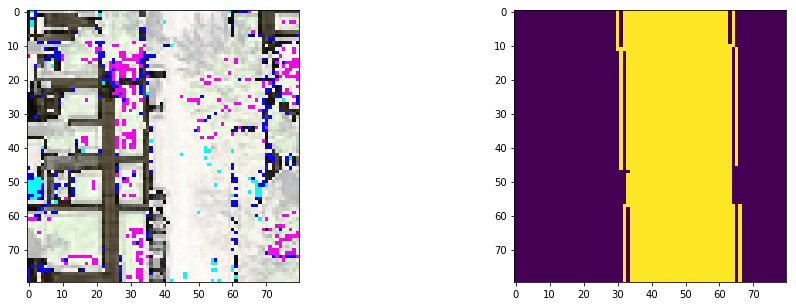

In [4]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.imshow(useful_patches_full[1])
plt.subplot(1,2,2)
plt.imshow(useful_lab_full[1])

In [5]:
def weighted_pixelwise_crossentropy(y_true, y_pred, class_weights):
    """computes pixelwise crossentropy"""
    temp = tf.clip_by_value(y_pred, 1e-8, 1. - 1e-8)
    loss = - tf.reduce_mean(tf.multiply(y_true * tf.log(temp), class_weights))
    return loss

In [6]:
learning_rate = tf.placeholder(tf.float32)
reg = 1e-3
n_filters = 64
kernel_size = 3

#saver = tf.train.Saver()

#tf_data = tf.placeholder(tf.float32,[None, 400,400,3])
tf_data = tf.placeholder(tf.float32,[None, None, None, 3])
tf_labels = tf.placeholder(tf.int32,[None,2])
keep_prob = tf.placeholder(tf.float32)
regularizer = tf.contrib.layers.l2_regularizer(scale=reg)

class_weights = tf.constant([[1.0,1.0]]) #left = more BG, right = more road in predictions
weights = tf.reduce_sum(class_weights * tf.cast(tf_labels, tf.float32), axis=1)

conv1 = tf.layers.conv2d(inputs=tf_data, filters=n_filters, kernel_size=kernel_size, kernel_regularizer=regularizer, activation=tf.nn.leaky_relu, padding='SAME')
print("conv1 size", conv1.shape)

pool1 = tf.contrib.layers.max_pool2d(inputs=conv1, kernel_size=2, stride=2)
print("pool1 size", pool1.shape)

conv2 = tf.layers.conv2d(inputs=pool1, filters=n_filters*2, kernel_size=kernel_size, kernel_regularizer=regularizer, activation=tf.nn.leaky_relu, padding='SAME')
print("conv2 size", conv2.shape)

pool2 = tf.contrib.layers.max_pool2d(inputs=conv2, kernel_size=2, stride=2)
print("pool2 size", pool2.shape)

conv3 =tf.nn.dropout(tf.layers.conv2d(inputs=pool2, filters=n_filters*4, kernel_size=kernel_size, kernel_regularizer=regularizer, activation=tf.nn.leaky_relu, padding='SAME'),keep_prob) 
print("conv3 size", conv3.shape)

pool3 = tf.contrib.layers.max_pool2d(inputs=conv3, kernel_size=2, stride=2)
print("pool3 size", pool3.shape)

conv4 = tf.nn.dropout(tf.layers.conv2d(inputs=pool3, filters=n_filters*4, kernel_size=kernel_size, kernel_regularizer=regularizer, activation=tf.nn.leaky_relu, padding='SAME'),keep_prob)
print("conv4 size", conv4.shape)

pool4 = tf.contrib.layers.max_pool2d(inputs=conv4, kernel_size=2, stride=2)
print("pool4 size", pool4.shape)

deconv1 = tf.nn.dropout(tf.layers.conv2d_transpose(inputs=pool4, filters=n_filters*4, kernel_size=4, strides=2, kernel_regularizer=regularizer, activation=tf.nn.leaky_relu, padding='SAME'), keep_prob)
print("deconv1 size", deconv1.shape)

deconv2 = tf.nn.dropout(tf.layers.conv2d_transpose(inputs=deconv1, filters=n_filters*4, kernel_size=4, strides=2, kernel_regularizer=regularizer, activation=tf.nn.leaky_relu, padding='SAME'),keep_prob)
print("deconv2 size", deconv2.shape)

deconv3 = tf.layers.conv2d_transpose(inputs=deconv2, filters=n_filters*2, kernel_size=4, strides=2, kernel_regularizer=regularizer, activation=tf.nn.leaky_relu, padding='SAME')
print("deconv3 size", deconv3.shape)

deconv4 = tf.layers.conv2d_transpose(inputs=deconv3, filters=n_filters, kernel_size=4, strides=2, kernel_regularizer=regularizer, activation=tf.nn.leaky_relu, padding='SAME')
print("deconv4 size", deconv4.shape)

score_layer = tf.layers.conv2d(inputs=deconv4, filters=2, kernel_size=1,kernel_regularizer=regularizer)
print("score size", score_layer.shape)

logits = tf.reshape(score_layer, (-1,2))

cross_entropy = tf.losses.softmax_cross_entropy(onehot_labels=tf_labels, logits=logits, weights=weights)
reg_variables = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
reg_term = tf.contrib.layers.apply_regularization(regularizer, reg_variables)
loss = reg_term + cross_entropy

train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

preds = tf.argmax(logits,axis=1,output_type=tf.int32)
print(logits.shape)


conv1 size (?, ?, ?, 64)
pool1 size (?, ?, ?, 64)
conv2 size (?, ?, ?, 128)
pool2 size (?, ?, ?, 128)
conv3 size (?, ?, ?, 256)
pool3 size (?, ?, ?, 256)
conv4 size (?, ?, ?, 256)
pool4 size (?, ?, ?, 256)
deconv1 size (?, ?, ?, 256)
deconv2 size (?, ?, ?, 256)
deconv3 size (?, ?, ?, 128)
deconv4 size (?, ?, ?, 64)
score size (?, ?, ?, 2)
(?, 2)


In [7]:
##Model inference

n_epoch = 10
batch_size = 5
learning_rate_val = 1e-3

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

train_f1_ar = np.asarray([])
train_loss_ar = np.asarray([])

for epoch in range(1,n_epoch+1):
    indices = np.random.permutation(useful_lab_full.shape[0])
    
    for batch_iter in range(int(np.ceil(useful_lab_full.shape[0]/batch_size))):

        
        batch_idx = indices[batch_iter*batch_size:min((batch_iter+1)*batch_size, indices.shape[0])]
        batch_x = useful_patches_full[batch_idx]

        batch_y = one_hot_convert(np.reshape(useful_lab_full[batch_idx], [-1]),num_classes=2)        


        _, train_loss, train_cross_entropy, train_reg_term = sess.run([train_step, loss, cross_entropy, reg_term], feed_dict={tf_data : batch_x, tf_labels : batch_y, keep_prob : 0.8, learning_rate : learning_rate_val})

    last_f1 =0
    if epoch % 1 ==0:
        print("Recap epoch ", epoch)
        print("last minibatch: ")
        print("cross entropy : ", train_cross_entropy)
        print("reg term : ", train_reg_term)
        train_pred, train_loss, f1_train = predict_model(sess, preds, loss, tf_data, tf_labels, keep_prob, np_imgs, np_gt, nmax=5, size_out=400)
        
        print("train f1 : ", f1_train)
        print("train loss : ", train_loss)

        if f1_train < last_f1:
            learning_rate_val/=2
        last_f1 = f1_train
        
        train_f1_ar = np.append(train_f1_ar,f1_train)
        train_loss_ar = np.append(train_loss_ar,train_loss)


Recap epoch  1
last minibatch: 
cross entropy :  0.661922
reg term :  4.89366e-05
train f1 :  0.591371307992
train loss :  0.662107414007
Recap epoch  2
last minibatch: 
cross entropy :  0.327061
reg term :  7.61011e-05
train f1 :  0.763374390769
train loss :  0.40705075413
Recap epoch  3
last minibatch: 
cross entropy :  0.271464
reg term :  0.000123373
train f1 :  0.790615749316
train loss :  0.338736168295
Recap epoch  4
last minibatch: 
cross entropy :  0.312605
reg term :  0.000185612
train f1 :  0.793020283958
train loss :  0.363295268267
Recap epoch  5
last minibatch: 
cross entropy :  0.578615
reg term :  0.000267147
train f1 :  0.832015648418
train loss :  0.304199186713
Recap epoch  6
last minibatch: 
cross entropy :  0.275308
reg term :  0.000363654
train f1 :  0.84059863465
train loss :  0.26976377964
Recap epoch  7
last minibatch: 
cross entropy :  0.217445
reg term :  0.000479444
train f1 :  0.85899852318
train loss :  0.235392194241
Recap epoch  8
last minibatch: 
cross 

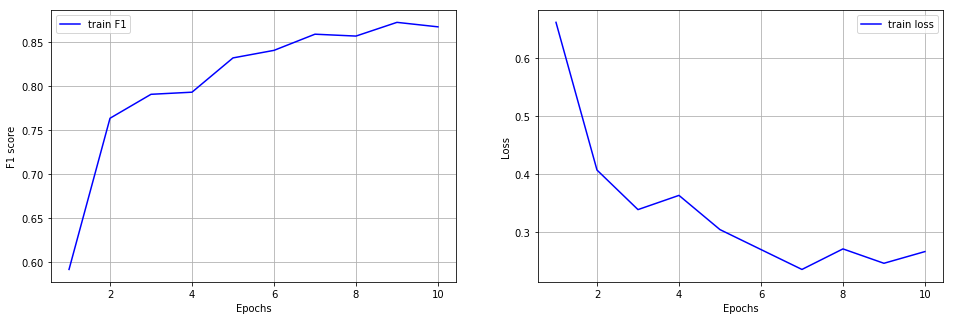

In [22]:
epoch_range = np.linspace(1,n_epoch,n_epoch)

plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(epoch_range,train_f1_ar,'-b', label='train F1')
plt.xlabel('Epochs')
plt.ylabel('F1 score')
plt.grid()
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch_range,train_loss_ar,'-b', label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

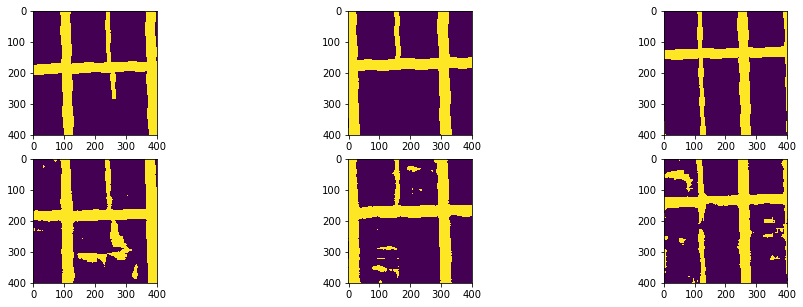

In [9]:
test2 = np.reshape(train_pred, np_gt.shape).astype(np.float32)

plt.figure(figsize=(16, 5))
plt.subplot(2,3,1)
plt.imshow(np_gt[1,:])
plt.subplot(2,3,2)
plt.imshow(np_gt[2,:])
plt.subplot(2,3,3)
plt.imshow(np_gt[3,:])
plt.subplot(2,3,4)
plt.imshow(test2[1,:])
plt.subplot(2,3,5)
plt.imshow(test2[2,:])
plt.subplot(2,3,6)
plt.imshow(test2[3,:])

0.554841 -0.130482
0.554841 -0.0861919
1.00512 -0.30863
1.00512 -0.263966
2.47884 -0.549311
2.47884 -0.350705
6.81044 -1.52652
6.81044 -1.22237
14.4882 -3.1544
42.5527 -6.82423
140.892 -28.455
64.8684 -12.6069
34.3225 -43.3091


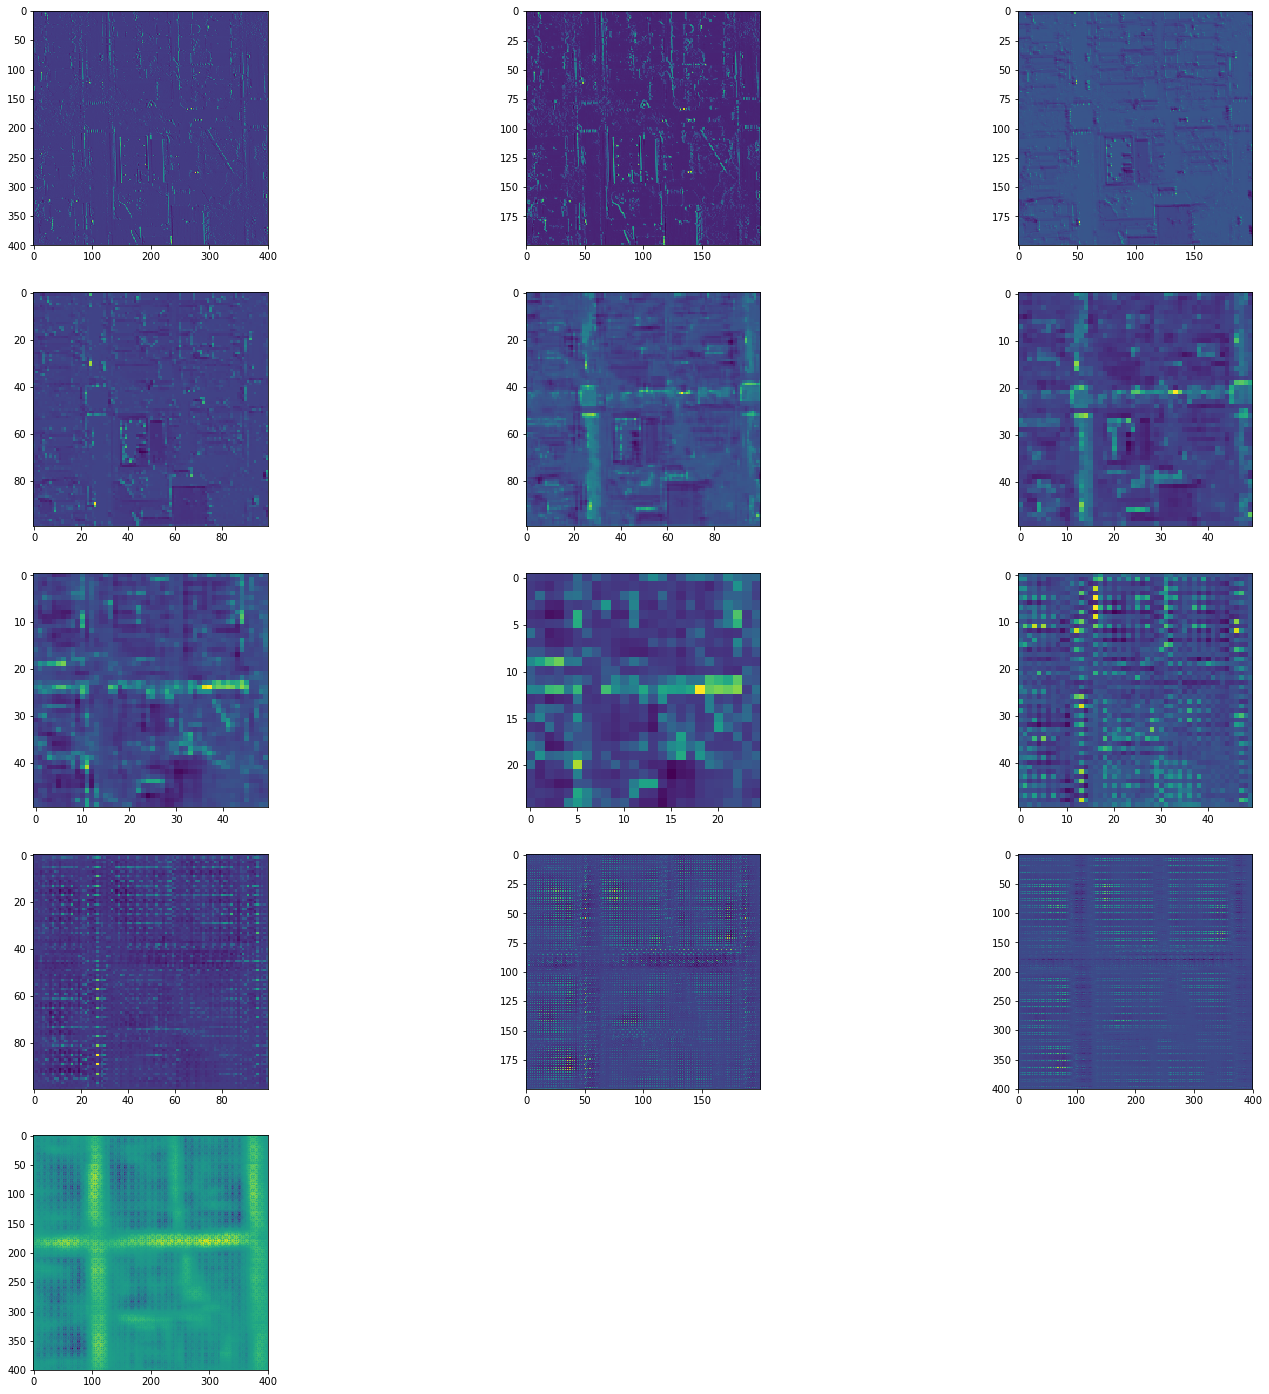

In [10]:
conv_1, pool_1, conv_2, pool_2,conv_3, pool_3, conv_4, pool_4, deconv_1, deconv_2, deconv_3, deconv_4, score= sess.run([conv1, pool1, conv2, pool2, conv3, pool3, conv4, pool4, deconv1, deconv2, deconv3, deconv4, score_layer], feed_dict={tf_data : np.expand_dims(np_imgs[1], axis=0), keep_prob : 1, tf_labels : one_hot_convert(np.reshape(np_gt[1],400*400).astype(int),2)})

print(max(np.reshape(conv_1, [-1])), min(np.reshape(conv_1, [-1])))
print(max(np.reshape(pool_1, [-1])), min(np.reshape(pool_1, [-1])))
print(max(np.reshape(conv_2, [-1])), min(np.reshape(conv_2, [-1])))
print(max(np.reshape(pool_2, [-1])), min(np.reshape(pool_2, [-1])))
print(max(np.reshape(conv_3, [-1])), min(np.reshape(conv_3, [-1])))
print(max(np.reshape(pool_3, [-1])), min(np.reshape(pool_3, [-1])))
print(max(np.reshape(conv_4, [-1])), min(np.reshape(conv_4, [-1])))
print(max(np.reshape(pool_4, [-1])), min(np.reshape(pool_4, [-1])))
print(max(np.reshape(deconv_1, [-1])), min(np.reshape(deconv_1, [-1])))
print(max(np.reshape(deconv_2, [-1])), min(np.reshape(deconv_2, [-1])))
print(max(np.reshape(deconv_3, [-1])), min(np.reshape(deconv_3, [-1])))
print(max(np.reshape(deconv_4, [-1])), min(np.reshape(deconv_4, [-1])))
print(max(np.reshape(score, [-1])), min(np.reshape(score, [-1])))

plt.figure(figsize=(25,25))
plt.subplot(5,3,1)
plt.imshow((np.asarray(np.squeeze(conv_1)[:,:,1])))
plt.subplot(5,3,2)
plt.imshow((np.asarray(np.squeeze(pool_1)[:,:,1])))
plt.subplot(5,3,3)
plt.imshow((np.asarray(np.squeeze(conv_2)[:,:,1])))
plt.subplot(5,3,4)
plt.imshow((np.asarray(np.squeeze(pool_2)[:,:,1])))
plt.subplot(5,3,5)
plt.imshow((np.asarray(np.squeeze(conv_3)[:,:,1])))
plt.subplot(5,3,6)
plt.imshow((np.asarray(np.squeeze(pool_3)[:,:,1])))
plt.subplot(5,3,7)
plt.imshow((np.asarray(np.squeeze(conv_4)[:,:,1])))
plt.subplot(5,3,8)
plt.imshow((np.asarray(np.squeeze(pool_4)[:,:,1])))
plt.subplot(5,3,9)
plt.imshow((np.asarray(np.squeeze(deconv_1)[:,:,1])))
plt.subplot(5,3,10)
plt.imshow((np.asarray(np.squeeze(deconv_2)[:,:,1])))
plt.subplot(5,3,11)
plt.imshow((np.asarray(np.squeeze(deconv_3)[:,:,1])))
plt.subplot(5,3,12)
plt.imshow((np.asarray(np.squeeze(deconv_4)[:,:,1])))
plt.subplot(5,3,13)
plt.imshow((np.asarray(np.squeeze(score)[:,:,1])))


# Post-processing

In [11]:
import skimage.measure
import skimage.draw
import skimage.morphology
def post_processing(img):
    
    img_no_small_obj = skimage.morphology.remove_small_objects(img.astype(bool), min_size = 200)
    
    #expanded_image = np.zeros(shape=(img.shape[0]+2, img.shape[1]+2))
    #expanded_image[1:-1,1:-1] = img_no_small_obj
    #contours = skimage.measure.find_contours(expanded_image, level=0.5)
    #mask = np.zeros(expanded_image.shape)
    #print(mask.shape)
    #for contour in contours:
    #    if len(contour[:,0]) > 10:
    #        if min(contour[:,0]<=2) or min(contour[:,1]<=2) or max(contour[:,0]>=img.shape[0]-1) or max(contour[:,1]>=img.shape[1]-1):
    #            rr,cc = skimage.draw.polygon(contour[:,0]+1, contour[:,1]+1)

    #            mask[rr,cc] = 1

    #real_mask = mask[1:-1,1:-1]
    
    return img_no_small_obj
    #return real_mask

After Post-Processing:
F1 training : 0.871164


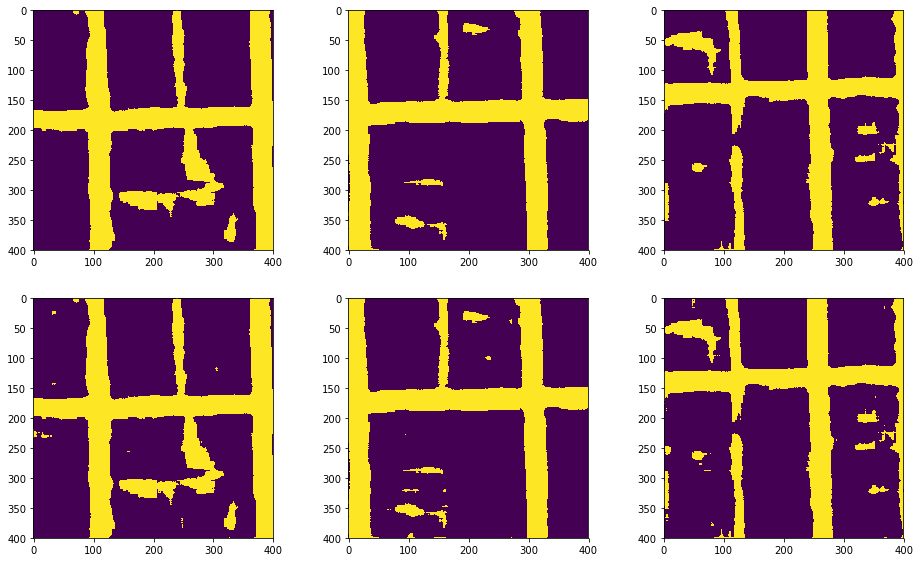

In [12]:
train_postproc = np.zeros(test2.shape)

img_cnt=0
for img in test2:
    train_postproc[img_cnt] = post_processing(img) 
    img_cnt+=1
    
F1_tr_postproc = f1_score(np.reshape(np_gt, [-1]), np.reshape(train_postproc, [-1]), average='macro')


print("After Post-Processing:")
print("F1 training : {:f}".format(F1_tr_postproc))
plt.figure(figsize=(16, 15))
plt.subplot(3,3,1)
plt.imshow(train_postproc[1,:])
plt.subplot(3,3,2)
plt.imshow(train_postproc[2,:])
plt.subplot(3,3,3)
plt.imshow(train_postproc[3,:])
plt.subplot(3,3,4)
plt.imshow(test2[1,:])
plt.subplot(3,3,5)
plt.imshow(test2[2,:])
plt.subplot(3,3,6)
plt.imshow(test2[3,:])

# Testing

In [13]:
#Test set

def load_test_set(dir_, data='test_set_images'):
    # Build path to root folder defined by data
    path_data = os.path.join(dir_, data)
    # Look for all file sin subfolder, store filename and path to filename (each test file is in a separate folder)
    files_data = []
    path_test = []
    for path, subdirs, files in os.walk(path_data):
        for name in files:
            files_data.append(name)
            path_test.append(path)
    # Get file ids to sort them (usedul for submission)
    id_files = [int(file.replace('test_', '').replace('.png', '')) for file in files_data]
    files_data = np.array(files_data)[np.argsort(id_files)]
    path_test = np.array(path_test)[np.argsort(id_files)]
    # Load firt file to get shape of images test and create dummy empty vector
    shape_test = mpimg.imread(os.path.join(path_test[0], files_data[0])).shape
    x_data = np.zeros((len(files_data),) + shape_test)
    # Load all test images in subfolders
    for i, (path, file) in enumerate(zip(path_test, files_data)):
        x_data[i] = mpimg.imread(os.path.join(path, file))
    
    return x_data

def patch_to_label(patch, foreground_threshold=0.25):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0
    
def create_submission(y_pred, submission_filename, images_size=608, patch_size=16):
    n_patches = images_size//patch_size
    text = 'id,prediction'
    with open(submission_filename, 'w') as f:
        f.write('id,prediction')
        for i in range(y_pred.shape[0]):
            im = y_pred[i]
            for j in range(0, im.shape[1], patch_size):
                for k in range(0, im.shape[0], patch_size):
                    patch = im[k:k + patch_size, j:j + patch_size]
                    label = patch_to_label(patch)
                    name = '{:03d}_{}_{},{}'.format(i+1, j, k, label)
                    f.write('\n'+name)

In [14]:
test_data = load_test_set('.')

In [15]:
test_data_norm = normalize_data(test_data)

In [16]:
#predictions
test_pred_part1 = sess.run([preds], feed_dict={tf_data : test_data_norm[:25,:], keep_prob : 1})
test_pred_part2 = sess.run([preds], feed_dict={tf_data : test_data_norm[25:,:], keep_prob : 1})


In [17]:
test_pred = np.concatenate((np.asarray(test_pred_part1), np.asarray(test_pred_part2)), axis=0)

In [18]:
test_pred_img = np.reshape(np.squeeze(test_pred), (-1, 608, 608))
#post processing
test_postproc = np.zeros(test_pred_img.shape)

img_cnt=0
for img in test_pred_img:
    print("Post Processing image {:d}".format(img_cnt))
    test_postproc[img_cnt] = post_processing(img)
    img_cnt+=1
    mpimg.imsave('./test_pred/pred_img{:d}.png'.format(img_cnt),test_postproc[img_cnt-1] )

Post Processing image 0
Post Processing image 1
Post Processing image 2
Post Processing image 3
Post Processing image 4
Post Processing image 5
Post Processing image 6
Post Processing image 7
Post Processing image 8
Post Processing image 9
Post Processing image 10
Post Processing image 11
Post Processing image 12
Post Processing image 13
Post Processing image 14
Post Processing image 15
Post Processing image 16
Post Processing image 17
Post Processing image 18
Post Processing image 19
Post Processing image 20
Post Processing image 21
Post Processing image 22
Post Processing image 23
Post Processing image 24
Post Processing image 25
Post Processing image 26
Post Processing image 27
Post Processing image 28
Post Processing image 29
Post Processing image 30
Post Processing image 31
Post Processing image 32
Post Processing image 33
Post Processing image 34
Post Processing image 35
Post Processing image 36
Post Processing image 37
Post Processing image 38
Post Processing image 39
Post Proce

In [19]:
create_submission(test_postproc, 'test_{:d}epoch_fulltrain_no_weighting_4layer_remove_small_patch3x3.csv'.format(n_epoch))